##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multiclass classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
print(tf.__version__)

2.3.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 22:55

   24576/84125825 [..............................] - ETA: 15:17

   40960/84125825 [..............................] - ETA: 13:46

   73728/84125825 [..............................] - ETA: 10:12

   90112/84125825 [..............................] - ETA: 10:25

  106496/84125825 [..............................] - ETA: 10:35

  139264/84125825 [..............................] - ETA: 9:26 

  172032/84125825 [..............................] - ETA: 8:44

  221184/84125825 [..............................] - ETA: 7:38

  286720/84125825 [..............................] - ETA: 6:32

  335872/84125825 [..............................] - ETA: 6:08

  401408/84125825 [..............................] - ETA: 5:36

  499712/84125825 [..............................] - ETA: 4:52

  581632/84125825 [..............................] - ETA: 4:30

  679936/84125825 [..............................] - ETA: 4:07

  794624/84125825 [..............................] - ETA: 3:45

  925696/84125825 [..............................] - ETA: 3:25

 1073152/84125825 [..............................] - ETA: 3:07

 1236992/84125825 [..............................] - ETA: 2:51

 1433600/84125825 [..............................] - ETA: 2:35

 1662976/84125825 [..............................] - ETA: 2:19

 1957888/84125825 [..............................] - ETA: 2:04

 2301952/84125825 [..............................] - ETA: 1:49

 2760704/84125825 [..............................] - ETA: 1:35

 3334144/84125825 [>.............................] - ETA: 1:21

 4038656/84125825 [>.............................] - ETA: 1:09

 4939776/84125825 [>.............................] - ETA: 58s 

 6070272/84125825 [=>............................] - ETA: 48s

 7512064/84125825 [=>............................] - ETA: 39s

 9248768/84125825 [==>...........................] - ETA: 32s

11280384/84125825 [===>..........................] - ETA: 26s

13721600/84125825 [===>..........................] - ETA: 22s

16392192/84125825 [====>.........................] - ETA: 18s

19226624/84125825 [=====>........................] - ETA: 15s

22306816/84125825 [======>.......................] - ETA: 13s

25436160/84125825 [========>.....................] - ETA: 11s

28565504/84125825 [=========>....................] - ETA: 9s 

28581888/84125825 [=========>....................] - ETA: 9s

31694848/84125825 [==========>...................] - ETA: 8s

31711232/84125825 [==========>...................] - ETA: 8s

34824192/84125825 [===========>..................] - ETA: 7s

37904384/84125825 [============>.................] - ETA: 6s

37969920/84125825 [============>.................] - ETA: 6s

40574976/84125825 [=============>................] - ETA: 5s

41066496/84125825 [=============>................] - ETA: 5s

43114496/84125825 [==============>...............] - ETA: 5s

44195840/84125825 [==============>...............] - ETA: 5s

46006272/84125825 [===============>..............] - ETA: 4s

47341568/84125825 [===============>..............] - ETA: 4s

48734208/84125825 [================>.............] - ETA: 4s

50487296/84125825 [=================>............] - ETA: 3s

51503104/84125825 [=================>............] - ETA: 3s

53600256/84125825 [==================>...........] - ETA: 3s

54484992/84125825 [==================>...........] - ETA: 3s

56745984/84125825 [===================>..........] - ETA: 2s

57597952/84125825 [===================>..........] - ETA: 2s

59875328/84125825 [====================>.........] - ETA: 2s

60727296/84125825 [====================>.........] - ETA: 2s

63004672/84125825 [=====================>........] - ETA: 2s

63791104/84125825 [=====================>........] - ETA: 2s

66052096/84125825 [======================>.......] - ETA: 1s

66428928/84125825 [======================>.......] - ETA: 1s

66969600/84125825 [======================>.......] - ETA: 1s

69214208/84125825 [=======================>......] - ETA: 1s

70033408/84125825 [=======================>......] - ETA: 1s

71213056/84125825 [========================>.....] - ETA: 1s

72671232/84125825 [========================>.....] - ETA: 1s

73211904/84125825 [=========================>....] - ETA: 1s

75505664/84125825 [=========================>....] - ETA: 0s

76324864/84125825 [==========================>...] - ETA: 0s

78635008/84125825 [===========================>..] - ETA: 0s

79437824/84125825 [===========================>..] - ETA: 0s

81764352/84125825 [============================>.] - ETA: 0s

82567168/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 7s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdbEr.txt', 'train', 'test', 'imdb.vocab', 'README']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'unsupBow.feat',
 'unsup',
 'pos',
 'urls_unsup.txt',
 'labeledBow.feat',
 'neg',
 'urls_pos.txt']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Note: The Preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `preprocessing.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowecase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create our neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 0s - loss: 0.6941 - binary_accuracy: 0.4688

 13/625 [..............................] - ETA: 2s - loss: 0.6928 - binary_accuracy: 0.5433

 26/625 [>.............................] - ETA: 2s - loss: 0.6927 - binary_accuracy: 0.5373

 39/625 [>.............................] - ETA: 2s - loss: 0.6927 - binary_accuracy: 0.5272

 52/625 [=>............................] - ETA: 2s - loss: 0.6925 - binary_accuracy: 0.5312

 65/625 [==>...........................] - ETA: 2s - loss: 0.6922 - binary_accuracy: 0.5346

 79/625 [==>...........................] - ETA: 2s - loss: 0.6919 - binary_accuracy: 0.5340

 93/625 [===>..........................] - ETA: 2s - loss: 0.6918 - binary_accuracy: 0.5269

107/625 [====>.........................] - ETA: 2s - loss: 0.6918 - binary_accuracy: 0.5184

121/625 [====>.........................] - ETA: 1s - loss: 0.6916 - binary_accuracy: 0.5240

134/625 [=====>........................] - ETA: 1s - loss: 0.6914 - binary_accuracy: 0.5385

148/625 [======>.......................] - ETA: 1s - loss: 0.6911 - binary_accuracy: 0.5513

161/625 [======>.......................] - ETA: 1s - loss: 0.6909 - binary_accuracy: 0.5635

174/625 [=======>......................] - ETA: 1s - loss: 0.6906 - binary_accuracy: 0.5736

187/625 [=======>......................] - ETA: 1s - loss: 0.6902 - binary_accuracy: 0.5805

200/625 [========>.....................] - ETA: 1s - loss: 0.6900 - binary_accuracy: 0.5817

213/625 [=========>....................] - ETA: 1s - loss: 0.6896 - binary_accuracy: 0.5873

227/625 [=========>....................] - ETA: 1s - loss: 0.6892 - binary_accuracy: 0.5965

240/625 [==========>...................] - ETA: 1s - loss: 0.6887 - binary_accuracy: 0.6033

254/625 [===========>..................] - ETA: 1s - loss: 0.6881 - binary_accuracy: 0.6100

267/625 [===========>..................] - ETA: 1s - loss: 0.6876 - binary_accuracy: 0.6139

280/625 [============>.................] - ETA: 1s - loss: 0.6870 - binary_accuracy: 0.6185

293/625 [=============>................] - ETA: 1s - loss: 0.6866 - binary_accuracy: 0.6223

306/625 [=============>................] - ETA: 1s - loss: 0.6861 - binary_accuracy: 0.6260

319/625 [==============>...............] - ETA: 1s - loss: 0.6856 - binary_accuracy: 0.6281

332/625 [==============>...............] - ETA: 1s - loss: 0.6850 - binary_accuracy: 0.6304

345/625 [===============>..............] - ETA: 1s - loss: 0.6845 - binary_accuracy: 0.6332

358/625 [================>.............] - ETA: 1s - loss: 0.6839 - binary_accuracy: 0.6352

372/625 [================>.............] - ETA: 0s - loss: 0.6830 - binary_accuracy: 0.6390

386/625 [=================>............] - ETA: 0s - loss: 0.6821 - binary_accuracy: 0.6434

400/625 [==================>...........] - ETA: 0s - loss: 0.6813 - binary_accuracy: 0.6472

413/625 [==================>...........] - ETA: 0s - loss: 0.6806 - binary_accuracy: 0.6507

427/625 [===================>..........] - ETA: 0s - loss: 0.6796 - binary_accuracy: 0.6546

441/625 [====================>.........] - ETA: 0s - loss: 0.6788 - binary_accuracy: 0.6572

454/625 [====================>.........] - ETA: 0s - loss: 0.6781 - binary_accuracy: 0.6598

468/625 [=====================>........] - ETA: 0s - loss: 0.6772 - binary_accuracy: 0.6617

482/625 [======================>.......] - ETA: 0s - loss: 0.6762 - binary_accuracy: 0.6639

496/625 [======================>.......] - ETA: 0s - loss: 0.6751 - binary_accuracy: 0.6674

510/625 [=======================>......] - ETA: 0s - loss: 0.6741 - binary_accuracy: 0.6694

524/625 [========================>.....] - ETA: 0s - loss: 0.6731 - binary_accuracy: 0.6726

537/625 [========================>.....] - ETA: 0s - loss: 0.6720 - binary_accuracy: 0.6748

551/625 [=========================>....] - ETA: 0s - loss: 0.6712 - binary_accuracy: 0.6768

565/625 [==========================>...] - ETA: 0s - loss: 0.6699 - binary_accuracy: 0.6783

579/625 [==========================>...] - ETA: 0s - loss: 0.6689 - binary_accuracy: 0.6804

593/625 [===========================>..] - ETA: 0s - loss: 0.6677 - binary_accuracy: 0.6831

607/625 [============================>.] - ETA: 0s - loss: 0.6666 - binary_accuracy: 0.6844

621/625 [============================>.] - ETA: 0s - loss: 0.6655 - binary_accuracy: 0.6862

625/625 [==============================] - 3s 5ms/step - loss: 0.6652 - binary_accuracy: 0.6866 - val_loss: 0.6146 - val_binary_accuracy: 0.7714


Epoch 2/10
  1/625 [..............................] - ETA: 0s - loss: 0.6180 - binary_accuracy: 0.7812

 15/625 [..............................] - ETA: 2s - loss: 0.6102 - binary_accuracy: 0.7792

 30/625 [>.............................] - ETA: 2s - loss: 0.6117 - binary_accuracy: 0.7656

 45/625 [=>............................] - ETA: 2s - loss: 0.6091 - binary_accuracy: 0.7708

 59/625 [=>............................] - ETA: 1s - loss: 0.6062 - binary_accuracy: 0.7717

 74/625 [==>...........................] - ETA: 1s - loss: 0.6052 - binary_accuracy: 0.7715

 88/625 [===>..........................] - ETA: 1s - loss: 0.6019 - binary_accuracy: 0.7745

103/625 [===>..........................] - ETA: 1s - loss: 0.5998 - binary_accuracy: 0.7776

118/625 [====>.........................] - ETA: 1s - loss: 0.5999 - binary_accuracy: 0.7741

133/625 [=====>........................] - ETA: 1s - loss: 0.5982 - binary_accuracy: 0.7742

147/625 [======>.......................] - ETA: 1s - loss: 0.5964 - binary_accuracy: 0.7755

162/625 [======>.......................] - ETA: 1s - loss: 0.5953 - binary_accuracy: 0.7766

177/625 [=======>......................] - ETA: 1s - loss: 0.5937 - binary_accuracy: 0.7772

192/625 [========>.....................] - ETA: 1s - loss: 0.5914 - binary_accuracy: 0.7796

207/625 [========>.....................] - ETA: 1s - loss: 0.5897 - binary_accuracy: 0.7785

222/625 [=========>....................] - ETA: 1s - loss: 0.5888 - binary_accuracy: 0.7789

237/625 [==========>...................] - ETA: 1s - loss: 0.5868 - binary_accuracy: 0.7806

252/625 [===========>..................] - ETA: 1s - loss: 0.5848 - binary_accuracy: 0.7814

266/625 [===========>..................] - ETA: 1s - loss: 0.5828 - binary_accuracy: 0.7837

280/625 [============>.................] - ETA: 1s - loss: 0.5807 - binary_accuracy: 0.7857

294/625 [=============>................] - ETA: 1s - loss: 0.5801 - binary_accuracy: 0.7850

309/625 [=============>................] - ETA: 1s - loss: 0.5792 - binary_accuracy: 0.7838

324/625 [==============>...............] - ETA: 1s - loss: 0.5781 - binary_accuracy: 0.7835

339/625 [===============>..............] - ETA: 1s - loss: 0.5770 - binary_accuracy: 0.7836

354/625 [===============>..............] - ETA: 0s - loss: 0.5751 - binary_accuracy: 0.7853

369/625 [================>.............] - ETA: 0s - loss: 0.5731 - binary_accuracy: 0.7866

383/625 [=================>............] - ETA: 0s - loss: 0.5714 - binary_accuracy: 0.7875

398/625 [==================>...........] - ETA: 0s - loss: 0.5694 - binary_accuracy: 0.7895

413/625 [==================>...........] - ETA: 0s - loss: 0.5676 - binary_accuracy: 0.7907

427/625 [===================>..........] - ETA: 0s - loss: 0.5659 - binary_accuracy: 0.7914

442/625 [====================>.........] - ETA: 0s - loss: 0.5648 - binary_accuracy: 0.7926

457/625 [====================>.........] - ETA: 0s - loss: 0.5633 - binary_accuracy: 0.7936

472/625 [=====================>........] - ETA: 0s - loss: 0.5621 - binary_accuracy: 0.7944

487/625 [======================>.......] - ETA: 0s - loss: 0.5604 - binary_accuracy: 0.7951

502/625 [=======================>......] - ETA: 0s - loss: 0.5585 - binary_accuracy: 0.7968

517/625 [=======================>......] - ETA: 0s - loss: 0.5569 - binary_accuracy: 0.7973

532/625 [========================>.....] - ETA: 0s - loss: 0.5553 - binary_accuracy: 0.7982

547/625 [=========================>....] - ETA: 0s - loss: 0.5539 - binary_accuracy: 0.7987

561/625 [=========================>....] - ETA: 0s - loss: 0.5528 - binary_accuracy: 0.7988

576/625 [==========================>...] - ETA: 0s - loss: 0.5513 - binary_accuracy: 0.8000

590/625 [===========================>..] - ETA: 0s - loss: 0.5501 - binary_accuracy: 0.8003

605/625 [============================>.] - ETA: 0s - loss: 0.5489 - binary_accuracy: 0.8008

620/625 [============================>.] - ETA: 0s - loss: 0.5477 - binary_accuracy: 0.8009

625/625 [==============================] - 3s 4ms/step - loss: 0.5474 - binary_accuracy: 0.8011 - val_loss: 0.4967 - val_binary_accuracy: 0.8216


Epoch 3/10
  1/625 [..............................] - ETA: 0s - loss: 0.4904 - binary_accuracy: 0.8125

 16/625 [..............................] - ETA: 2s - loss: 0.4809 - binary_accuracy: 0.8359

 31/625 [>.............................] - ETA: 2s - loss: 0.4878 - binary_accuracy: 0.8155

 46/625 [=>............................] - ETA: 2s - loss: 0.4848 - binary_accuracy: 0.8247

 60/625 [=>............................] - ETA: 1s - loss: 0.4843 - binary_accuracy: 0.8240

 74/625 [==>...........................] - ETA: 1s - loss: 0.4837 - binary_accuracy: 0.8260

 88/625 [===>..........................] - ETA: 1s - loss: 0.4808 - binary_accuracy: 0.8267

103/625 [===>..........................] - ETA: 1s - loss: 0.4785 - binary_accuracy: 0.8307

117/625 [====>.........................] - ETA: 1s - loss: 0.4794 - binary_accuracy: 0.8283

131/625 [=====>........................] - ETA: 1s - loss: 0.4780 - binary_accuracy: 0.8271

145/625 [=====>........................] - ETA: 1s - loss: 0.4766 - binary_accuracy: 0.8272

160/625 [======>.......................] - ETA: 1s - loss: 0.4769 - binary_accuracy: 0.8258

175/625 [=======>......................] - ETA: 1s - loss: 0.4748 - binary_accuracy: 0.8291

189/625 [========>.....................] - ETA: 1s - loss: 0.4731 - binary_accuracy: 0.8294

204/625 [========>.....................] - ETA: 1s - loss: 0.4723 - binary_accuracy: 0.8294

219/625 [=========>....................] - ETA: 1s - loss: 0.4725 - binary_accuracy: 0.8293

233/625 [==========>...................] - ETA: 1s - loss: 0.4705 - binary_accuracy: 0.8309

247/625 [==========>...................] - ETA: 1s - loss: 0.4691 - binary_accuracy: 0.8314

262/625 [===========>..................] - ETA: 1s - loss: 0.4671 - binary_accuracy: 0.8331

277/625 [============>.................] - ETA: 1s - loss: 0.4647 - binary_accuracy: 0.8351

291/625 [============>.................] - ETA: 1s - loss: 0.4654 - binary_accuracy: 0.8339

306/625 [=============>................] - ETA: 1s - loss: 0.4657 - binary_accuracy: 0.8327

321/625 [==============>...............] - ETA: 1s - loss: 0.4651 - binary_accuracy: 0.8327

336/625 [===============>..............] - ETA: 1s - loss: 0.4648 - binary_accuracy: 0.8329

350/625 [===============>..............] - ETA: 0s - loss: 0.4630 - binary_accuracy: 0.8347

365/625 [================>.............] - ETA: 0s - loss: 0.4611 - binary_accuracy: 0.8365

380/625 [=================>............] - ETA: 0s - loss: 0.4596 - binary_accuracy: 0.8367

395/625 [=================>............] - ETA: 0s - loss: 0.4583 - binary_accuracy: 0.8380

410/625 [==================>...........] - ETA: 0s - loss: 0.4567 - binary_accuracy: 0.8390

424/625 [===================>..........] - ETA: 0s - loss: 0.4556 - binary_accuracy: 0.8392

438/625 [====================>.........] - ETA: 0s - loss: 0.4546 - binary_accuracy: 0.8399

452/625 [====================>.........] - ETA: 0s - loss: 0.4544 - binary_accuracy: 0.8401

466/625 [=====================>........] - ETA: 0s - loss: 0.4531 - binary_accuracy: 0.8411

481/625 [======================>.......] - ETA: 0s - loss: 0.4526 - binary_accuracy: 0.8408

496/625 [======================>.......] - ETA: 0s - loss: 0.4508 - binary_accuracy: 0.8422

511/625 [=======================>......] - ETA: 0s - loss: 0.4500 - binary_accuracy: 0.8429

525/625 [========================>.....] - ETA: 0s - loss: 0.4484 - binary_accuracy: 0.8435

540/625 [========================>.....] - ETA: 0s - loss: 0.4478 - binary_accuracy: 0.8438

554/625 [=========================>....] - ETA: 0s - loss: 0.4472 - binary_accuracy: 0.8439

568/625 [==========================>...] - ETA: 0s - loss: 0.4461 - binary_accuracy: 0.8442

583/625 [==========================>...] - ETA: 0s - loss: 0.4455 - binary_accuracy: 0.8446

597/625 [===========================>..] - ETA: 0s - loss: 0.4447 - binary_accuracy: 0.8452

611/625 [============================>.] - ETA: 0s - loss: 0.4445 - binary_accuracy: 0.8446

625/625 [==============================] - 3s 4ms/step - loss: 0.4440 - binary_accuracy: 0.8445 - val_loss: 0.4189 - val_binary_accuracy: 0.8470


Epoch 4/10
  1/625 [..............................] - ETA: 0s - loss: 0.4131 - binary_accuracy: 0.8438

 16/625 [..............................] - ETA: 2s - loss: 0.3973 - binary_accuracy: 0.8652

 31/625 [>.............................] - ETA: 2s - loss: 0.4028 - binary_accuracy: 0.8538

 46/625 [=>............................] - ETA: 2s - loss: 0.4002 - binary_accuracy: 0.8580

 60/625 [=>............................] - ETA: 1s - loss: 0.4023 - binary_accuracy: 0.8562

 75/625 [==>...........................] - ETA: 1s - loss: 0.4014 - binary_accuracy: 0.8571

 89/625 [===>..........................] - ETA: 1s - loss: 0.4022 - binary_accuracy: 0.8550

104/625 [===>..........................] - ETA: 1s - loss: 0.3996 - binary_accuracy: 0.8582

118/625 [====>.........................] - ETA: 1s - loss: 0.4001 - binary_accuracy: 0.8581

132/625 [=====>........................] - ETA: 1s - loss: 0.3993 - binary_accuracy: 0.8546

147/625 [======>.......................] - ETA: 1s - loss: 0.3980 - binary_accuracy: 0.8554

161/625 [======>.......................] - ETA: 1s - loss: 0.3991 - binary_accuracy: 0.8540

175/625 [=======>......................] - ETA: 1s - loss: 0.3970 - binary_accuracy: 0.8568

189/625 [========>.....................] - ETA: 1s - loss: 0.3950 - binary_accuracy: 0.8585

204/625 [========>.....................] - ETA: 1s - loss: 0.3947 - binary_accuracy: 0.8592

219/625 [=========>....................] - ETA: 1s - loss: 0.3955 - binary_accuracy: 0.8589

234/625 [==========>...................] - ETA: 1s - loss: 0.3939 - binary_accuracy: 0.8592

249/625 [==========>...................] - ETA: 1s - loss: 0.3929 - binary_accuracy: 0.8592

264/625 [===========>..................] - ETA: 1s - loss: 0.3914 - binary_accuracy: 0.8603

279/625 [============>.................] - ETA: 1s - loss: 0.3896 - binary_accuracy: 0.8614

294/625 [=============>................] - ETA: 1s - loss: 0.3913 - binary_accuracy: 0.8607

309/625 [=============>................] - ETA: 1s - loss: 0.3917 - binary_accuracy: 0.8600

323/625 [==============>...............] - ETA: 1s - loss: 0.3912 - binary_accuracy: 0.8600

337/625 [===============>..............] - ETA: 1s - loss: 0.3912 - binary_accuracy: 0.8601

351/625 [===============>..............] - ETA: 0s - loss: 0.3900 - binary_accuracy: 0.8614

365/625 [================>.............] - ETA: 0s - loss: 0.3883 - binary_accuracy: 0.8625

379/625 [=================>............] - ETA: 0s - loss: 0.3871 - binary_accuracy: 0.8633

393/625 [=================>............] - ETA: 0s - loss: 0.3865 - binary_accuracy: 0.8633

407/625 [==================>...........] - ETA: 0s - loss: 0.3852 - binary_accuracy: 0.8637

421/625 [===================>..........] - ETA: 0s - loss: 0.3840 - binary_accuracy: 0.8646

435/625 [===================>..........] - ETA: 0s - loss: 0.3837 - binary_accuracy: 0.8644

449/625 [====================>.........] - ETA: 0s - loss: 0.3834 - binary_accuracy: 0.8640

464/625 [=====================>........] - ETA: 0s - loss: 0.3823 - binary_accuracy: 0.8648

479/625 [=====================>........] - ETA: 0s - loss: 0.3824 - binary_accuracy: 0.8648

493/625 [======================>.......] - ETA: 0s - loss: 0.3811 - binary_accuracy: 0.8656

508/625 [=======================>......] - ETA: 0s - loss: 0.3801 - binary_accuracy: 0.8661

523/625 [========================>.....] - ETA: 0s - loss: 0.3791 - binary_accuracy: 0.8661

537/625 [========================>.....] - ETA: 0s - loss: 0.3784 - binary_accuracy: 0.8666

551/625 [=========================>....] - ETA: 0s - loss: 0.3786 - binary_accuracy: 0.8665

566/625 [==========================>...] - ETA: 0s - loss: 0.3777 - binary_accuracy: 0.8669

581/625 [==========================>...] - ETA: 0s - loss: 0.3777 - binary_accuracy: 0.8666

596/625 [===========================>..] - ETA: 0s - loss: 0.3773 - binary_accuracy: 0.8670

610/625 [============================>.] - ETA: 0s - loss: 0.3775 - binary_accuracy: 0.8666

625/625 [==============================] - ETA: 0s - loss: 0.3773 - binary_accuracy: 0.8662

625/625 [==============================] - 3s 4ms/step - loss: 0.3773 - binary_accuracy: 0.8662 - val_loss: 0.3731 - val_binary_accuracy: 0.8614


Epoch 5/10
  1/625 [..............................] - ETA: 0s - loss: 0.3677 - binary_accuracy: 0.8750

 15/625 [..............................] - ETA: 2s - loss: 0.3484 - binary_accuracy: 0.8813

 29/625 [>.............................] - ETA: 2s - loss: 0.3579 - binary_accuracy: 0.8707

 44/625 [=>............................] - ETA: 2s - loss: 0.3501 - binary_accuracy: 0.8757

 58/625 [=>............................] - ETA: 2s - loss: 0.3515 - binary_accuracy: 0.8728

 72/625 [==>...........................] - ETA: 1s - loss: 0.3509 - binary_accuracy: 0.8728

 86/625 [===>..........................] - ETA: 1s - loss: 0.3503 - binary_accuracy: 0.8721

100/625 [===>..........................] - ETA: 1s - loss: 0.3497 - binary_accuracy: 0.8734

114/625 [====>.........................] - ETA: 1s - loss: 0.3489 - binary_accuracy: 0.8725

128/625 [=====>........................] - ETA: 1s - loss: 0.3483 - binary_accuracy: 0.8716

143/625 [=====>........................] - ETA: 1s - loss: 0.3480 - binary_accuracy: 0.8708

158/625 [======>.......................] - ETA: 1s - loss: 0.3492 - binary_accuracy: 0.8710

173/625 [=======>......................] - ETA: 1s - loss: 0.3481 - binary_accuracy: 0.8716

188/625 [========>.....................] - ETA: 1s - loss: 0.3463 - binary_accuracy: 0.8728

202/625 [========>.....................] - ETA: 1s - loss: 0.3462 - binary_accuracy: 0.8731

216/625 [=========>....................] - ETA: 1s - loss: 0.3478 - binary_accuracy: 0.8724

230/625 [==========>...................] - ETA: 1s - loss: 0.3467 - binary_accuracy: 0.8731

243/625 [==========>...................] - ETA: 1s - loss: 0.3464 - binary_accuracy: 0.8720

257/625 [===========>..................] - ETA: 1s - loss: 0.3437 - binary_accuracy: 0.8746

270/625 [===========>..................] - ETA: 1s - loss: 0.3434 - binary_accuracy: 0.8747

284/625 [============>.................] - ETA: 1s - loss: 0.3438 - binary_accuracy: 0.8747

297/625 [=============>................] - ETA: 1s - loss: 0.3458 - binary_accuracy: 0.8730

311/625 [=============>................] - ETA: 1s - loss: 0.3461 - binary_accuracy: 0.8723

324/625 [==============>...............] - ETA: 1s - loss: 0.3459 - binary_accuracy: 0.8722

337/625 [===============>..............] - ETA: 1s - loss: 0.3455 - binary_accuracy: 0.8718

350/625 [===============>..............] - ETA: 1s - loss: 0.3439 - binary_accuracy: 0.8729

364/625 [================>.............] - ETA: 0s - loss: 0.3429 - binary_accuracy: 0.8737

377/625 [=================>............] - ETA: 0s - loss: 0.3415 - binary_accuracy: 0.8747

390/625 [=================>............] - ETA: 0s - loss: 0.3412 - binary_accuracy: 0.8748

403/625 [==================>...........] - ETA: 0s - loss: 0.3407 - binary_accuracy: 0.8749

417/625 [===================>..........] - ETA: 0s - loss: 0.3395 - binary_accuracy: 0.8754

430/625 [===================>..........] - ETA: 0s - loss: 0.3388 - binary_accuracy: 0.8757

443/625 [====================>.........] - ETA: 0s - loss: 0.3389 - binary_accuracy: 0.8756

457/625 [====================>.........] - ETA: 0s - loss: 0.3385 - binary_accuracy: 0.8761

472/625 [=====================>........] - ETA: 0s - loss: 0.3385 - binary_accuracy: 0.8763

486/625 [======================>.......] - ETA: 0s - loss: 0.3378 - binary_accuracy: 0.8767

500/625 [=======================>......] - ETA: 0s - loss: 0.3366 - binary_accuracy: 0.8777

514/625 [=======================>......] - ETA: 0s - loss: 0.3361 - binary_accuracy: 0.8777

529/625 [========================>.....] - ETA: 0s - loss: 0.3349 - binary_accuracy: 0.8782

544/625 [=========================>....] - ETA: 0s - loss: 0.3355 - binary_accuracy: 0.8777

558/625 [=========================>....] - ETA: 0s - loss: 0.3350 - binary_accuracy: 0.8779

573/625 [==========================>...] - ETA: 0s - loss: 0.3346 - binary_accuracy: 0.8782

587/625 [===========================>..] - ETA: 0s - loss: 0.3348 - binary_accuracy: 0.8778

602/625 [===========================>..] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8779

616/625 [============================>.] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8776

625/625 [==============================] - 3s 4ms/step - loss: 0.3352 - binary_accuracy: 0.8774 - val_loss: 0.3446 - val_binary_accuracy: 0.8668


Epoch 6/10
  1/625 [..............................] - ETA: 0s - loss: 0.3609 - binary_accuracy: 0.8750

 16/625 [..............................] - ETA: 1s - loss: 0.3120 - binary_accuracy: 0.8965

 31/625 [>.............................] - ETA: 1s - loss: 0.3174 - binary_accuracy: 0.8871

 45/625 [=>............................] - ETA: 1s - loss: 0.3149 - binary_accuracy: 0.8868

 60/625 [=>............................] - ETA: 1s - loss: 0.3156 - binary_accuracy: 0.8859

 75/625 [==>...........................] - ETA: 1s - loss: 0.3146 - binary_accuracy: 0.8854

 89/625 [===>..........................] - ETA: 1s - loss: 0.3174 - binary_accuracy: 0.8820

104/625 [===>..........................] - ETA: 1s - loss: 0.3156 - binary_accuracy: 0.8840

119/625 [====>.........................] - ETA: 1s - loss: 0.3156 - binary_accuracy: 0.8821

134/625 [=====>........................] - ETA: 1s - loss: 0.3146 - binary_accuracy: 0.8815

149/625 [======>.......................] - ETA: 1s - loss: 0.3140 - binary_accuracy: 0.8830

163/625 [======>.......................] - ETA: 1s - loss: 0.3166 - binary_accuracy: 0.8806

178/625 [=======>......................] - ETA: 1s - loss: 0.3142 - binary_accuracy: 0.8822

193/625 [========>.....................] - ETA: 1s - loss: 0.3111 - binary_accuracy: 0.8844

208/625 [========>.....................] - ETA: 1s - loss: 0.3125 - binary_accuracy: 0.8837

222/625 [=========>....................] - ETA: 1s - loss: 0.3127 - binary_accuracy: 0.8839

237/625 [==========>...................] - ETA: 1s - loss: 0.3117 - binary_accuracy: 0.8838

251/625 [===========>..................] - ETA: 1s - loss: 0.3117 - binary_accuracy: 0.8841

266/625 [===========>..................] - ETA: 1s - loss: 0.3112 - binary_accuracy: 0.8846

281/625 [============>.................] - ETA: 1s - loss: 0.3106 - binary_accuracy: 0.8856

296/625 [=============>................] - ETA: 1s - loss: 0.3131 - binary_accuracy: 0.8838

311/625 [=============>................] - ETA: 1s - loss: 0.3138 - binary_accuracy: 0.8828

326/625 [==============>...............] - ETA: 1s - loss: 0.3137 - binary_accuracy: 0.8824

341/625 [===============>..............] - ETA: 0s - loss: 0.3131 - binary_accuracy: 0.8829

356/625 [================>.............] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8836

371/625 [================>.............] - ETA: 0s - loss: 0.3100 - binary_accuracy: 0.8842

386/625 [=================>............] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8843

401/625 [==================>...........] - ETA: 0s - loss: 0.3090 - binary_accuracy: 0.8850

415/625 [==================>...........] - ETA: 0s - loss: 0.3079 - binary_accuracy: 0.8851

429/625 [===================>..........] - ETA: 0s - loss: 0.3073 - binary_accuracy: 0.8853

443/625 [====================>.........] - ETA: 0s - loss: 0.3073 - binary_accuracy: 0.8852

458/625 [====================>.........] - ETA: 0s - loss: 0.3071 - binary_accuracy: 0.8852

473/625 [=====================>........] - ETA: 0s - loss: 0.3069 - binary_accuracy: 0.8856

488/625 [======================>.......] - ETA: 0s - loss: 0.3062 - binary_accuracy: 0.8858

503/625 [=======================>......] - ETA: 0s - loss: 0.3049 - binary_accuracy: 0.8867

518/625 [=======================>......] - ETA: 0s - loss: 0.3043 - binary_accuracy: 0.8869

533/625 [========================>.....] - ETA: 0s - loss: 0.3038 - binary_accuracy: 0.8870

548/625 [=========================>....] - ETA: 0s - loss: 0.3039 - binary_accuracy: 0.8871

563/625 [==========================>...] - ETA: 0s - loss: 0.3035 - binary_accuracy: 0.8870

578/625 [==========================>...] - ETA: 0s - loss: 0.3038 - binary_accuracy: 0.8870

593/625 [===========================>..] - ETA: 0s - loss: 0.3044 - binary_accuracy: 0.8869

608/625 [============================>.] - ETA: 0s - loss: 0.3049 - binary_accuracy: 0.8867

623/625 [============================>.] - ETA: 0s - loss: 0.3048 - binary_accuracy: 0.8867

625/625 [==============================] - 3s 4ms/step - loss: 0.3047 - binary_accuracy: 0.8867 - val_loss: 0.3257 - val_binary_accuracy: 0.8720


Epoch 7/10
  1/625 [..............................] - ETA: 0s - loss: 0.3109 - binary_accuracy: 0.9062

 15/625 [..............................] - ETA: 2s - loss: 0.2859 - binary_accuracy: 0.9062

 30/625 [>.............................] - ETA: 2s - loss: 0.2935 - binary_accuracy: 0.8958

 44/625 [=>............................] - ETA: 2s - loss: 0.2858 - binary_accuracy: 0.8984

 58/625 [=>............................] - ETA: 2s - loss: 0.2892 - binary_accuracy: 0.8966

 73/625 [==>...........................] - ETA: 1s - loss: 0.2892 - binary_accuracy: 0.8964

 88/625 [===>..........................] - ETA: 1s - loss: 0.2894 - binary_accuracy: 0.8952

103/625 [===>..........................] - ETA: 1s - loss: 0.2897 - binary_accuracy: 0.8953

118/625 [====>.........................] - ETA: 1s - loss: 0.2914 - binary_accuracy: 0.8935

132/625 [=====>........................] - ETA: 1s - loss: 0.2906 - binary_accuracy: 0.8928

146/625 [======>.......................] - ETA: 1s - loss: 0.2899 - binary_accuracy: 0.8934

161/625 [======>.......................] - ETA: 1s - loss: 0.2912 - binary_accuracy: 0.8915

176/625 [=======>......................] - ETA: 1s - loss: 0.2896 - binary_accuracy: 0.8922

191/625 [========>.....................] - ETA: 1s - loss: 0.2860 - binary_accuracy: 0.8945

206/625 [========>.....................] - ETA: 1s - loss: 0.2874 - binary_accuracy: 0.8941

221/625 [=========>....................] - ETA: 1s - loss: 0.2878 - binary_accuracy: 0.8934

236/625 [==========>...................] - ETA: 1s - loss: 0.2867 - binary_accuracy: 0.8935

251/625 [===========>..................] - ETA: 1s - loss: 0.2872 - binary_accuracy: 0.8932

266/625 [===========>..................] - ETA: 1s - loss: 0.2869 - binary_accuracy: 0.8937

281/625 [============>.................] - ETA: 1s - loss: 0.2861 - binary_accuracy: 0.8947

295/625 [=============>................] - ETA: 1s - loss: 0.2878 - binary_accuracy: 0.8934

310/625 [=============>................] - ETA: 1s - loss: 0.2889 - binary_accuracy: 0.8929

325/625 [==============>...............] - ETA: 1s - loss: 0.2885 - binary_accuracy: 0.8925

339/625 [===============>..............] - ETA: 1s - loss: 0.2883 - binary_accuracy: 0.8928

353/625 [===============>..............] - ETA: 0s - loss: 0.2866 - binary_accuracy: 0.8934

368/625 [================>.............] - ETA: 0s - loss: 0.2858 - binary_accuracy: 0.8934

383/625 [=================>............] - ETA: 0s - loss: 0.2856 - binary_accuracy: 0.8942

398/625 [==================>...........] - ETA: 0s - loss: 0.2850 - binary_accuracy: 0.8944

412/625 [==================>...........] - ETA: 0s - loss: 0.2836 - binary_accuracy: 0.8949

427/625 [===================>..........] - ETA: 0s - loss: 0.2833 - binary_accuracy: 0.8948

441/625 [====================>.........] - ETA: 0s - loss: 0.2831 - binary_accuracy: 0.8951

454/625 [====================>.........] - ETA: 0s - loss: 0.2833 - binary_accuracy: 0.8949

467/625 [=====================>........] - ETA: 0s - loss: 0.2828 - binary_accuracy: 0.8951

480/625 [======================>.......] - ETA: 0s - loss: 0.2830 - binary_accuracy: 0.8951

494/625 [======================>.......] - ETA: 0s - loss: 0.2819 - binary_accuracy: 0.8959

508/625 [=======================>......] - ETA: 0s - loss: 0.2810 - binary_accuracy: 0.8968

522/625 [========================>.....] - ETA: 0s - loss: 0.2806 - binary_accuracy: 0.8965

536/625 [========================>.....] - ETA: 0s - loss: 0.2804 - binary_accuracy: 0.8967

550/625 [=========================>....] - ETA: 0s - loss: 0.2811 - binary_accuracy: 0.8964

564/625 [==========================>...] - ETA: 0s - loss: 0.2803 - binary_accuracy: 0.8969

578/625 [==========================>...] - ETA: 0s - loss: 0.2808 - binary_accuracy: 0.8967

593/625 [===========================>..] - ETA: 0s - loss: 0.2813 - binary_accuracy: 0.8966

608/625 [============================>.] - ETA: 0s - loss: 0.2818 - binary_accuracy: 0.8964

622/625 [============================>.] - ETA: 0s - loss: 0.2816 - binary_accuracy: 0.8964

625/625 [==============================] - 3s 4ms/step - loss: 0.2815 - binary_accuracy: 0.8964 - val_loss: 0.3131 - val_binary_accuracy: 0.8726


Epoch 8/10
  1/625 [..............................] - ETA: 0s - loss: 0.2956 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 2s - loss: 0.2615 - binary_accuracy: 0.9141

 31/625 [>.............................] - ETA: 2s - loss: 0.2677 - binary_accuracy: 0.9032

 46/625 [=>............................] - ETA: 1s - loss: 0.2624 - binary_accuracy: 0.9035

 60/625 [=>............................] - ETA: 1s - loss: 0.2671 - binary_accuracy: 0.9021

 74/625 [==>...........................] - ETA: 1s - loss: 0.2677 - binary_accuracy: 0.9012

 88/625 [===>..........................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.9006

103/625 [===>..........................] - ETA: 1s - loss: 0.2688 - binary_accuracy: 0.9020

118/625 [====>.........................] - ETA: 1s - loss: 0.2708 - binary_accuracy: 0.9002

132/625 [=====>........................] - ETA: 1s - loss: 0.2698 - binary_accuracy: 0.8999

147/625 [======>.......................] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9005

162/625 [======>.......................] - ETA: 1s - loss: 0.2702 - binary_accuracy: 0.8985

177/625 [=======>......................] - ETA: 1s - loss: 0.2688 - binary_accuracy: 0.8992

191/625 [========>.....................] - ETA: 1s - loss: 0.2660 - binary_accuracy: 0.9012

206/625 [========>.....................] - ETA: 1s - loss: 0.2678 - binary_accuracy: 0.9003

220/625 [=========>....................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.8997

234/625 [==========>...................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.8994

249/625 [==========>...................] - ETA: 1s - loss: 0.2690 - binary_accuracy: 0.8991

263/625 [===========>..................] - ETA: 1s - loss: 0.2680 - binary_accuracy: 0.9007

277/625 [============>.................] - ETA: 1s - loss: 0.2671 - binary_accuracy: 0.9014

291/625 [============>.................] - ETA: 1s - loss: 0.2678 - binary_accuracy: 0.9012

305/625 [=============>................] - ETA: 1s - loss: 0.2696 - binary_accuracy: 0.9006

319/625 [==============>...............] - ETA: 1s - loss: 0.2703 - binary_accuracy: 0.8997

333/625 [==============>...............] - ETA: 1s - loss: 0.2690 - binary_accuracy: 0.9004

347/625 [===============>..............] - ETA: 0s - loss: 0.2678 - binary_accuracy: 0.9008

361/625 [================>.............] - ETA: 0s - loss: 0.2676 - binary_accuracy: 0.9011

375/625 [=================>............] - ETA: 0s - loss: 0.2660 - binary_accuracy: 0.9019

389/625 [=================>............] - ETA: 0s - loss: 0.2654 - binary_accuracy: 0.9026

403/625 [==================>...........] - ETA: 0s - loss: 0.2653 - binary_accuracy: 0.9029

417/625 [===================>..........] - ETA: 0s - loss: 0.2640 - binary_accuracy: 0.9033

432/625 [===================>..........] - ETA: 0s - loss: 0.2636 - binary_accuracy: 0.9032

446/625 [====================>.........] - ETA: 0s - loss: 0.2637 - binary_accuracy: 0.9034

461/625 [=====================>........] - ETA: 0s - loss: 0.2629 - binary_accuracy: 0.9037

475/625 [=====================>........] - ETA: 0s - loss: 0.2634 - binary_accuracy: 0.9037

490/625 [======================>.......] - ETA: 0s - loss: 0.2629 - binary_accuracy: 0.9039

505/625 [=======================>......] - ETA: 0s - loss: 0.2614 - binary_accuracy: 0.9047

520/625 [=======================>......] - ETA: 0s - loss: 0.2610 - binary_accuracy: 0.9047

535/625 [========================>.....] - ETA: 0s - loss: 0.2608 - binary_accuracy: 0.9048

550/625 [=========================>....] - ETA: 0s - loss: 0.2617 - binary_accuracy: 0.9046

565/625 [==========================>...] - ETA: 0s - loss: 0.2609 - binary_accuracy: 0.9054

579/625 [==========================>...] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9049

594/625 [===========================>..] - ETA: 0s - loss: 0.2621 - binary_accuracy: 0.9051

609/625 [============================>.] - ETA: 0s - loss: 0.2630 - binary_accuracy: 0.9042

624/625 [============================>.] - ETA: 0s - loss: 0.2628 - binary_accuracy: 0.9042

625/625 [==============================] - 3s 4ms/step - loss: 0.2628 - binary_accuracy: 0.9043 - val_loss: 0.3036 - val_binary_accuracy: 0.8764


Epoch 9/10
  1/625 [..............................] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8750

 15/625 [..............................] - ETA: 2s - loss: 0.2473 - binary_accuracy: 0.9083

 30/625 [>.............................] - ETA: 2s - loss: 0.2503 - binary_accuracy: 0.9083

 44/625 [=>............................] - ETA: 2s - loss: 0.2439 - binary_accuracy: 0.9148

 59/625 [=>............................] - ETA: 1s - loss: 0.2474 - binary_accuracy: 0.9147

 74/625 [==>...........................] - ETA: 1s - loss: 0.2494 - binary_accuracy: 0.9109

 89/625 [===>..........................] - ETA: 1s - loss: 0.2546 - binary_accuracy: 0.9094

104/625 [===>..........................] - ETA: 1s - loss: 0.2541 - binary_accuracy: 0.9093

119/625 [====>.........................] - ETA: 1s - loss: 0.2540 - binary_accuracy: 0.9091

134/625 [=====>........................] - ETA: 1s - loss: 0.2526 - binary_accuracy: 0.9086

149/625 [======>.......................] - ETA: 1s - loss: 0.2521 - binary_accuracy: 0.9086

164/625 [======>.......................] - ETA: 1s - loss: 0.2547 - binary_accuracy: 0.9057

179/625 [=======>......................] - ETA: 1s - loss: 0.2515 - binary_accuracy: 0.9078

194/625 [========>.....................] - ETA: 1s - loss: 0.2494 - binary_accuracy: 0.9087

208/625 [========>.....................] - ETA: 1s - loss: 0.2508 - binary_accuracy: 0.9085

222/625 [=========>....................] - ETA: 1s - loss: 0.2512 - binary_accuracy: 0.9089

237/625 [==========>...................] - ETA: 1s - loss: 0.2505 - binary_accuracy: 0.9088

252/625 [===========>..................] - ETA: 1s - loss: 0.2510 - binary_accuracy: 0.9080

267/625 [===========>..................] - ETA: 1s - loss: 0.2510 - binary_accuracy: 0.9081

282/625 [============>.................] - ETA: 1s - loss: 0.2508 - binary_accuracy: 0.9089

297/625 [=============>................] - ETA: 1s - loss: 0.2531 - binary_accuracy: 0.9078

312/625 [=============>................] - ETA: 1s - loss: 0.2542 - binary_accuracy: 0.9072

327/625 [==============>...............] - ETA: 1s - loss: 0.2530 - binary_accuracy: 0.9072

342/625 [===============>..............] - ETA: 0s - loss: 0.2522 - binary_accuracy: 0.9073

357/625 [================>.............] - ETA: 0s - loss: 0.2510 - binary_accuracy: 0.9081

372/625 [================>.............] - ETA: 0s - loss: 0.2495 - binary_accuracy: 0.9086

386/625 [=================>............] - ETA: 0s - loss: 0.2492 - binary_accuracy: 0.9084

401/625 [==================>...........] - ETA: 0s - loss: 0.2489 - binary_accuracy: 0.9088

415/625 [==================>...........] - ETA: 0s - loss: 0.2482 - binary_accuracy: 0.9090

429/625 [===================>..........] - ETA: 0s - loss: 0.2478 - binary_accuracy: 0.9089

443/625 [====================>.........] - ETA: 0s - loss: 0.2477 - binary_accuracy: 0.9090

458/625 [====================>.........] - ETA: 0s - loss: 0.2476 - binary_accuracy: 0.9092

472/625 [=====================>........] - ETA: 0s - loss: 0.2475 - binary_accuracy: 0.9091

486/625 [======================>.......] - ETA: 0s - loss: 0.2475 - binary_accuracy: 0.9090

500/625 [=======================>......] - ETA: 0s - loss: 0.2463 - binary_accuracy: 0.9099

515/625 [=======================>......] - ETA: 0s - loss: 0.2455 - binary_accuracy: 0.9106

530/625 [========================>.....] - ETA: 0s - loss: 0.2448 - binary_accuracy: 0.9106

545/625 [=========================>....] - ETA: 0s - loss: 0.2456 - binary_accuracy: 0.9101

560/625 [=========================>....] - ETA: 0s - loss: 0.2452 - binary_accuracy: 0.9105

574/625 [==========================>...] - ETA: 0s - loss: 0.2454 - binary_accuracy: 0.9104

589/625 [===========================>..] - ETA: 0s - loss: 0.2459 - binary_accuracy: 0.9100

604/625 [===========================>..] - ETA: 0s - loss: 0.2469 - binary_accuracy: 0.9098

619/625 [============================>.] - ETA: 0s - loss: 0.2470 - binary_accuracy: 0.9095

625/625 [==============================] - 3s 4ms/step - loss: 0.2471 - binary_accuracy: 0.9094 - val_loss: 0.2968 - val_binary_accuracy: 0.8776


Epoch 10/10
  1/625 [..............................] - ETA: 0s - loss: 0.2986 - binary_accuracy: 0.8750

 16/625 [..............................] - ETA: 1s - loss: 0.2315 - binary_accuracy: 0.9180

 30/625 [>.............................] - ETA: 2s - loss: 0.2366 - binary_accuracy: 0.9156

 44/625 [=>............................] - ETA: 2s - loss: 0.2287 - binary_accuracy: 0.9176

 59/625 [=>............................] - ETA: 1s - loss: 0.2338 - binary_accuracy: 0.9184

 74/625 [==>...........................] - ETA: 1s - loss: 0.2354 - binary_accuracy: 0.9160

 88/625 [===>..........................] - ETA: 1s - loss: 0.2360 - binary_accuracy: 0.9148

102/625 [===>..........................] - ETA: 1s - loss: 0.2379 - binary_accuracy: 0.9157

116/625 [====>.........................] - ETA: 1s - loss: 0.2380 - binary_accuracy: 0.9143

131/625 [=====>........................] - ETA: 1s - loss: 0.2377 - binary_accuracy: 0.9134

145/625 [=====>........................] - ETA: 1s - loss: 0.2376 - binary_accuracy: 0.9140

159/625 [======>.......................] - ETA: 1s - loss: 0.2378 - binary_accuracy: 0.9135

173/625 [=======>......................] - ETA: 1s - loss: 0.2368 - binary_accuracy: 0.9135

188/625 [========>.....................] - ETA: 1s - loss: 0.2348 - binary_accuracy: 0.9144

203/625 [========>.....................] - ETA: 1s - loss: 0.2343 - binary_accuracy: 0.9153

218/625 [=========>....................] - ETA: 1s - loss: 0.2362 - binary_accuracy: 0.9146

233/625 [==========>...................] - ETA: 1s - loss: 0.2365 - binary_accuracy: 0.9142

248/625 [==========>...................] - ETA: 1s - loss: 0.2365 - binary_accuracy: 0.9141

263/625 [===========>..................] - ETA: 1s - loss: 0.2361 - binary_accuracy: 0.9147

278/625 [============>.................] - ETA: 1s - loss: 0.2354 - binary_accuracy: 0.9158

292/625 [=============>................] - ETA: 1s - loss: 0.2364 - binary_accuracy: 0.9151

307/625 [=============>................] - ETA: 1s - loss: 0.2375 - binary_accuracy: 0.9150

321/625 [==============>...............] - ETA: 1s - loss: 0.2382 - binary_accuracy: 0.9140

336/625 [===============>..............] - ETA: 1s - loss: 0.2375 - binary_accuracy: 0.9142

351/625 [===============>..............] - ETA: 0s - loss: 0.2358 - binary_accuracy: 0.9150

366/625 [================>.............] - ETA: 0s - loss: 0.2345 - binary_accuracy: 0.9151

380/625 [=================>............] - ETA: 0s - loss: 0.2343 - binary_accuracy: 0.9153

395/625 [=================>............] - ETA: 0s - loss: 0.2336 - binary_accuracy: 0.9151

409/625 [==================>...........] - ETA: 0s - loss: 0.2328 - binary_accuracy: 0.9156

424/625 [===================>..........] - ETA: 0s - loss: 0.2328 - binary_accuracy: 0.9155

439/625 [====================>.........] - ETA: 0s - loss: 0.2322 - binary_accuracy: 0.9154

454/625 [====================>.........] - ETA: 0s - loss: 0.2323 - binary_accuracy: 0.9153

469/625 [=====================>........] - ETA: 0s - loss: 0.2322 - binary_accuracy: 0.9155

484/625 [======================>.......] - ETA: 0s - loss: 0.2323 - binary_accuracy: 0.9153

499/625 [======================>.......] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9156

514/625 [=======================>......] - ETA: 0s - loss: 0.2308 - binary_accuracy: 0.9163

529/625 [========================>.....] - ETA: 0s - loss: 0.2302 - binary_accuracy: 0.9164

544/625 [=========================>....] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9158

559/625 [=========================>....] - ETA: 0s - loss: 0.2310 - binary_accuracy: 0.9163

574/625 [==========================>...] - ETA: 0s - loss: 0.2310 - binary_accuracy: 0.9165

589/625 [===========================>..] - ETA: 0s - loss: 0.2315 - binary_accuracy: 0.9163

604/625 [===========================>..] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.9160

619/625 [============================>.] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.9156

625/625 [==============================] - 3s 4ms/step - loss: 0.2324 - binary_accuracy: 0.9155 - val_loss: 0.2923 - val_binary_accuracy: 0.8784


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.2156 - binary_accuracy: 0.8750

 16/782 [..............................] - ETA: 2s - loss: 0.3210 - binary_accuracy: 0.8730

 31/782 [>.............................] - ETA: 2s - loss: 0.3082 - binary_accuracy: 0.8821

 46/782 [>.............................] - ETA: 2s - loss: 0.3066 - binary_accuracy: 0.8804

 61/782 [=>............................] - ETA: 2s - loss: 0.2988 - binary_accuracy: 0.8822

 77/782 [=>............................] - ETA: 2s - loss: 0.3038 - binary_accuracy: 0.8795

 92/782 [==>...........................] - ETA: 2s - loss: 0.3064 - binary_accuracy: 0.8787

108/782 [===>..........................] - ETA: 2s - loss: 0.3008 - binary_accuracy: 0.8819

124/782 [===>..........................] - ETA: 2s - loss: 0.2991 - binary_accuracy: 0.8826

139/782 [====>.........................] - ETA: 2s - loss: 0.3021 - binary_accuracy: 0.8813

154/782 [====>.........................] - ETA: 2s - loss: 0.3071 - binary_accuracy: 0.8782

170/782 [=====>........................] - ETA: 2s - loss: 0.3103 - binary_accuracy: 0.8772

185/782 [======>.......................] - ETA: 1s - loss: 0.3073 - binary_accuracy: 0.8789

200/782 [======>.......................] - ETA: 1s - loss: 0.3070 - binary_accuracy: 0.8788

215/782 [=======>......................] - ETA: 1s - loss: 0.3053 - binary_accuracy: 0.8794

231/782 [=======>......................] - ETA: 1s - loss: 0.3059 - binary_accuracy: 0.8792

247/782 [========>.....................] - ETA: 1s - loss: 0.3077 - binary_accuracy: 0.8775

263/782 [=========>....................] - ETA: 1s - loss: 0.3050 - binary_accuracy: 0.8788

278/782 [=========>....................] - ETA: 1s - loss: 0.3060 - binary_accuracy: 0.8794

294/782 [==========>...................] - ETA: 1s - loss: 0.3053 - binary_accuracy: 0.8790

310/782 [==========>...................] - ETA: 1s - loss: 0.3052 - binary_accuracy: 0.8787

325/782 [===========>..................] - ETA: 1s - loss: 0.3032 - binary_accuracy: 0.8792

341/782 [============>.................] - ETA: 1s - loss: 0.3033 - binary_accuracy: 0.8790

356/782 [============>.................] - ETA: 1s - loss: 0.3032 - binary_accuracy: 0.8786

372/782 [=============>................] - ETA: 1s - loss: 0.3024 - binary_accuracy: 0.8793

387/782 [=============>................] - ETA: 1s - loss: 0.3020 - binary_accuracy: 0.8797

402/782 [==============>...............] - ETA: 1s - loss: 0.3027 - binary_accuracy: 0.8794

417/782 [==============>...............] - ETA: 1s - loss: 0.3036 - binary_accuracy: 0.8781

432/782 [===============>..............] - ETA: 1s - loss: 0.3037 - binary_accuracy: 0.8781

447/782 [================>.............] - ETA: 1s - loss: 0.3034 - binary_accuracy: 0.8784

462/782 [================>.............] - ETA: 1s - loss: 0.3051 - binary_accuracy: 0.8778

477/782 [=================>............] - ETA: 1s - loss: 0.3044 - binary_accuracy: 0.8779

492/782 [=================>............] - ETA: 0s - loss: 0.3043 - binary_accuracy: 0.8775

507/782 [==================>...........] - ETA: 0s - loss: 0.3048 - binary_accuracy: 0.8772

523/782 [===================>..........] - ETA: 0s - loss: 0.3046 - binary_accuracy: 0.8773

538/782 [===================>..........] - ETA: 0s - loss: 0.3067 - binary_accuracy: 0.8765

553/782 [====================>.........] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8762

569/782 [====================>.........] - ETA: 0s - loss: 0.3079 - binary_accuracy: 0.8760

584/782 [=====================>........] - ETA: 0s - loss: 0.3088 - binary_accuracy: 0.8752

600/782 [======================>.......] - ETA: 0s - loss: 0.3086 - binary_accuracy: 0.8752

615/782 [======================>.......] - ETA: 0s - loss: 0.3075 - binary_accuracy: 0.8755

630/782 [=======================>......] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8754

645/782 [=======================>......] - ETA: 0s - loss: 0.3080 - binary_accuracy: 0.8750

660/782 [========================>.....] - ETA: 0s - loss: 0.3088 - binary_accuracy: 0.8749

676/782 [========================>.....] - ETA: 0s - loss: 0.3090 - binary_accuracy: 0.8749

691/782 [=========================>....] - ETA: 0s - loss: 0.3093 - binary_accuracy: 0.8746

707/782 [==========================>...] - ETA: 0s - loss: 0.3094 - binary_accuracy: 0.8745

722/782 [==========================>...] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.8740

737/782 [===========================>..] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8742

752/782 [===========================>..] - ETA: 0s - loss: 0.3095 - binary_accuracy: 0.8744

768/782 [============================>.] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8736

782/782 [==============================] - 3s 3ms/step - loss: 0.3104 - binary_accuracy: 0.8735


Loss:  0.31036365032196045
Accuracy:  0.873520016670227


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

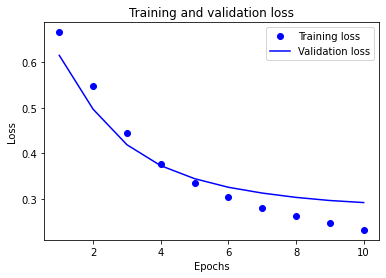

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

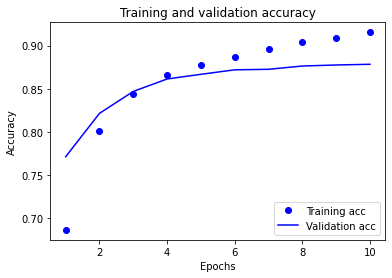

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?version=nightly).

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.1961 - accuracy: 0.9375

 11/782 [..............................] - ETA: 3s - loss: 0.3026 - accuracy: 0.8750

 22/782 [..............................] - ETA: 3s - loss: 0.2996 - accuracy: 0.8793

 33/782 [>.............................] - ETA: 3s - loss: 0.3018 - accuracy: 0.8826

 44/782 [>.............................] - ETA: 3s - loss: 0.3034 - accuracy: 0.8793

 54/782 [=>............................] - ETA: 3s - loss: 0.3053 - accuracy: 0.8773

 65/782 [=>............................] - ETA: 3s - loss: 0.3085 - accuracy: 0.8798

 76/782 [=>............................] - ETA: 3s - loss: 0.3023 - accuracy: 0.8824

 87/782 [==>...........................] - ETA: 3s - loss: 0.3028 - accuracy: 0.8818

 98/782 [==>...........................] - ETA: 3s - loss: 0.3022 - accuracy: 0.8820

109/782 [===>..........................] - ETA: 3s - loss: 0.3013 - accuracy: 0.8816

119/782 [===>..........................] - ETA: 3s - loss: 0.2982 - accuracy: 0.8837

130/782 [===>..........................] - ETA: 3s - loss: 0.3024 - accuracy: 0.8822

141/782 [====>.........................] - ETA: 3s - loss: 0.3036 - accuracy: 0.8810

152/782 [====>.........................] - ETA: 3s - loss: 0.3053 - accuracy: 0.8789

162/782 [=====>........................] - ETA: 3s - loss: 0.3087 - accuracy: 0.8775

173/782 [=====>........................] - ETA: 2s - loss: 0.3066 - accuracy: 0.8790

184/782 [======>.......................] - ETA: 2s - loss: 0.3071 - accuracy: 0.8789

195/782 [======>.......................] - ETA: 2s - loss: 0.3070 - accuracy: 0.8784

206/782 [======>.......................] - ETA: 2s - loss: 0.3058 - accuracy: 0.8792

217/782 [=======>......................] - ETA: 2s - loss: 0.3064 - accuracy: 0.8790

228/782 [=======>......................] - ETA: 2s - loss: 0.3078 - accuracy: 0.8782

239/782 [========>.....................] - ETA: 2s - loss: 0.3082 - accuracy: 0.8774

250/782 [========>.....................] - ETA: 2s - loss: 0.3087 - accuracy: 0.8771

261/782 [=========>....................] - ETA: 2s - loss: 0.3068 - accuracy: 0.8782

272/782 [=========>....................] - ETA: 2s - loss: 0.3063 - accuracy: 0.8789

283/782 [=========>....................] - ETA: 2s - loss: 0.3069 - accuracy: 0.8784

294/782 [==========>...................] - ETA: 2s - loss: 0.3062 - accuracy: 0.8787

305/782 [==========>...................] - ETA: 2s - loss: 0.3054 - accuracy: 0.8786

316/782 [===========>..................] - ETA: 2s - loss: 0.3035 - accuracy: 0.8793

327/782 [===========>..................] - ETA: 2s - loss: 0.3040 - accuracy: 0.8791

338/782 [===========>..................] - ETA: 2s - loss: 0.3041 - accuracy: 0.8784

349/782 [============>.................] - ETA: 2s - loss: 0.3042 - accuracy: 0.8783

360/782 [============>.................] - ETA: 2s - loss: 0.3025 - accuracy: 0.8793

371/782 [=============>................] - ETA: 1s - loss: 0.3027 - accuracy: 0.8790

382/782 [=============>................] - ETA: 1s - loss: 0.3016 - accuracy: 0.8797

393/782 [==============>...............] - ETA: 1s - loss: 0.3020 - accuracy: 0.8793

404/782 [==============>...............] - ETA: 1s - loss: 0.3034 - accuracy: 0.8786

415/782 [==============>...............] - ETA: 1s - loss: 0.3026 - accuracy: 0.8788

426/782 [===============>..............] - ETA: 1s - loss: 0.3036 - accuracy: 0.8779

437/782 [===============>..............] - ETA: 1s - loss: 0.3029 - accuracy: 0.8784

448/782 [================>.............] - ETA: 1s - loss: 0.3037 - accuracy: 0.8783

459/782 [================>.............] - ETA: 1s - loss: 0.3047 - accuracy: 0.8779

469/782 [================>.............] - ETA: 1s - loss: 0.3045 - accuracy: 0.8780

480/782 [=================>............] - ETA: 1s - loss: 0.3043 - accuracy: 0.8779

490/782 [=================>............] - ETA: 1s - loss: 0.3041 - accuracy: 0.8779

501/782 [==================>...........] - ETA: 1s - loss: 0.3049 - accuracy: 0.8770

512/782 [==================>...........] - ETA: 1s - loss: 0.3050 - accuracy: 0.8771

523/782 [===================>..........] - ETA: 1s - loss: 0.3047 - accuracy: 0.8772

534/782 [===================>..........] - ETA: 1s - loss: 0.3065 - accuracy: 0.8764

545/782 [===================>..........] - ETA: 1s - loss: 0.3079 - accuracy: 0.8758

555/782 [====================>.........] - ETA: 1s - loss: 0.3080 - accuracy: 0.8759

566/782 [====================>.........] - ETA: 1s - loss: 0.3078 - accuracy: 0.8759

577/782 [=====================>........] - ETA: 0s - loss: 0.3077 - accuracy: 0.8756

588/782 [=====================>........] - ETA: 0s - loss: 0.3086 - accuracy: 0.8750

598/782 [=====================>........] - ETA: 0s - loss: 0.3081 - accuracy: 0.8754

609/782 [======================>.......] - ETA: 0s - loss: 0.3085 - accuracy: 0.8750

620/782 [======================>.......] - ETA: 0s - loss: 0.3080 - accuracy: 0.8751

631/782 [=======================>......] - ETA: 0s - loss: 0.3072 - accuracy: 0.8754

642/782 [=======================>......] - ETA: 0s - loss: 0.3078 - accuracy: 0.8751

653/782 [========================>.....] - ETA: 0s - loss: 0.3082 - accuracy: 0.8750

664/782 [========================>.....] - ETA: 0s - loss: 0.3089 - accuracy: 0.8746

674/782 [========================>.....] - ETA: 0s - loss: 0.3099 - accuracy: 0.8742

685/782 [=========================>....] - ETA: 0s - loss: 0.3092 - accuracy: 0.8746

696/782 [=========================>....] - ETA: 0s - loss: 0.3090 - accuracy: 0.8746

707/782 [==========================>...] - ETA: 0s - loss: 0.3095 - accuracy: 0.8742

718/782 [==========================>...] - ETA: 0s - loss: 0.3095 - accuracy: 0.8741

728/782 [==========================>...] - ETA: 0s - loss: 0.3096 - accuracy: 0.8743

739/782 [===========================>..] - ETA: 0s - loss: 0.3096 - accuracy: 0.8744

750/782 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8739

761/782 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8739

772/782 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8739

782/782 [==============================] - 4s 5ms/step - loss: 0.3104 - accuracy: 0.8735


0.873520016670227


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multiclass classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multiclass classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

We have prepared a [dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: to increase the difficulty of the classification problem, we have replaced any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions with the word *blank* (as many questions contain the language they're about). 

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) we have prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications. 

1. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

1. When you compile your model, change the loss to [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?version=nightly). This is the correct loss function to use for a multiclass classification problem, when the labels for each class are integers (in our case, they can be 0, *1*, *2*, or *3*).

1. Once these changes are complete, you will be able to train a multiclass classifier. 

If you get stuck, you can find a solution [here](https://github.com/tensorflow/examples/blob/master/community/en/text_classification_solution.ipynb).


## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, we recommend reading [this guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
